## Conclusion : Comparaison KNN / ANN / SVM

In [2]:
#imports
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import metrics
from time import time
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [3]:
#load dataset
mnist = fetch_openml('mnist_784')

## [1] Echantillonage du jeu de données et séparation en entraînement/test

In [4]:
#choose sample size
dataset_length = len(mnist.data)
sample_size = 7000
sample_size = min(dataset_length,sample_size)

#extract sample from dataset
sample_indexes = np.random.randint(dataset_length, size= sample_size)
data, target = np.array([mnist.data[i] for i in sample_indexes]), np.array([mnist.target[i] for i in sample_indexes])

#extract train/test according to the proportion given in the subject
train_size = 70/100 #70% de test
d_train, d_test, l_train, l_test = train_test_split(data,target,train_size = train_size, random_state = 42)

## [2] Paramétrage des modèles
Nous utilisons les meilleurs paramètres obtenus suite aux 3 analyses individuelles de ces méthodes

#### KNN

In [13]:
n_nb = 3
dist = 2
knn = KNeighborsClassifier(n_nb, p = dist, n_jobs = 1)

#### MLP

In [20]:
layers_nb = 6
layers_size = 50
up_size = 1.25 * layers_size
down_size = 0.75*layers_size
#reduce neurons number logarithmically to help convergence
neurons = np.geomspace(up_size, 
                       down_size, 
                       num=layers_nb, 
                       dtype=int)
algo = 'lbfgs'
function = 'relu'
alpha = 0.1
mlp = MLPClassifier(hidden_layer_sizes=neurons, 
                    solver = algo, 
                    alpha = alpha, 
                    activation = function)

#### SVC

In [15]:
kernel = 'rbf'
c = 1.25
svc = SVC(kernel = kernel, C = c)

## [3] Analyse comparative
Pour cette analyse, nous comparerons les différentes modèles sur plusieurs critères :
- Précision
- Rappel
- Erreur
- Temps d'entraînement
- Temps de prédiction

In [21]:
methods = {"KNN":knn,"MLP":mlp,"SVC":svc}

In [22]:
plot = ([],[],[],[],[],[])
for name,clf in methods.items():
    print(name,end = '')
    train_start = time()
    clf.fit(d_train,l_train)
    train_duration = time()-train_start
    pred_start = time()
    prediction = clf.predict(d_test)
    pred_duration = time()-pred_start
    
    recall = metrics.recall_score(l_test, 
                                  prediction, 
                                  average = 'micro')
    score = metrics.precision_score(l_test, 
                                    prediction, 
                                    average='micro')
    error = metrics.zero_one_loss(l_test, 
                                  prediction)
    
    plot[0].append(name)
    plot[1].append(100*score)
    plot[2].append(100*recall)
    plot[3].append(error)
    plot[4].append(train_duration)
    plot[5].append(pred_duration)
    print(" | Done",score,"%",recall,"%",error,train_duration,"s",pred_duration,"s")

KNN | Done 0.9385714285714286 % 0.9385714285714286 % 0.06142857142857139 2.1697795391082764 s 20.056316375732422 s
MLP

c:\dev\python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 | Done 0.8785714285714286 % 0.8785714285714286 % 0.12142857142857144 17.085198402404785 s 0.01563572883605957 s
SVC | Done 0.9628571428571429 % 0.9628571428571429 % 0.037142857142857144 11.992031335830688 s 6.631431341171265 s


'Analyse comparative des trois méthodes'

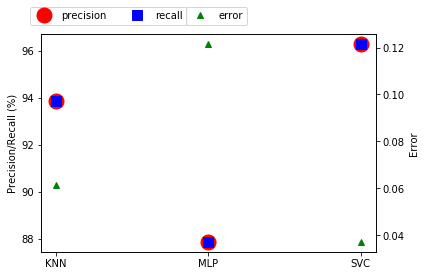

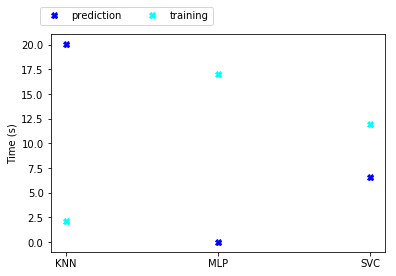

In [23]:
fig=plt.figure()
ax1=fig.add_subplot(111, label="scores")
ax2 = ax1.twinx()
ax2.plot(plot[0],plot[3],
         linestyle='None',
         marker='^',
         color='g', 
         label = 'error')
ax1.plot(plot[0],plot[1],
         linestyle='None', marker='o',
         ms=15.0, color='r',
         label='precision')
ax1.plot(plot[0],plot[2],
         linestyle='None',marker='s',
         ms=10,color='b',
         label='recall')

ax1.set_ylabel("Precision/Recall (%)")
ax2.set_ylabel("Error")
ax1.legend(ncol = 2, bbox_to_anchor=(0.45,1.15))
ax2.legend(bbox_to_anchor = (0.63, 1.15))

fig2 = plt.figure()
ax3 = fig2.add_subplot(111, label="times")
ax3.plot(plot[0],plot[5],
         linestyle='None',marker='X',
         color='b', label = 'prediction')
ax3.plot(plot[0],plot[4],
         linestyle='None',marker='X',
         color='cyan', label = 'training')

ax3.set_ylabel('Time (s)')
ax3.legend(ncol=2,bbox_to_anchor=(0.5,1.15))

"Analyse comparative des trois méthodes"

#### Interprétation
En terme de qualité de prédiction pure, le classifieur SVC semble plus indiqué que les deux autres méthodes,obtenant une précision/rappel supérieur à 94.5% contre 92% et 91.5% pour KNN et MLP respectivement. Le sscore d'erreur est également plus élevé pour ces deux modèles que pour SVC.

Le choix est en revanche plus nuancé si l'on s'intéresse aux temps d'exécution : Le temps de prédiction du modèle MLP est nettement inférieur à celui du modèle SVC, malgré un temps d'entraînement plus important. Or, si l'on se place dans un contexte d'utilisation 'réelle', le temps d'entraînement importe finalement peu, car il ne sera pris en compte qu'un nombre fini de fois contre une infinité potentielle de prédictions une fois en entraînement satisfaisant obtenu. Le modèle KNN semble donc le moins intéressant des trois sur ce critère, le temps d'entraînement étant quasi nul(logique car il s'agit uniquement de stocker le jeu de données d'entraînement) et le temps de prédiction bien supérieur aux deux autres modèles.

En conclusion, le choix se fera donc plutôt entre MLP et SVC, avec une préférence pour SVC si l'on valorise la qualité de la prédiction, et MLP si l'on priorise sa rapidité. KNN, bien qu'offrant en apparence un compromis entre les deux en terme de qualité, souffrira bien plus du passage à l'échelle sur des jeux de données plus grands.

## FIN TP